### Develop Model
This notebook is being used to create and test different mvp models for this project

In [24]:
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [25]:
import sys
sys.path.append(os.environ.get('PYTHONPATH'))
from config import config

In [36]:
pitching = pd.read_csv(os.path.join(config.PROJECT_ROOT_DIR, 'data', 'historical', 'pitchingHistorical.csv'), encoding = 'latin')
hitting = pd.read_csv(os.path.join(config.PROJECT_ROOT_DIR, 'data', 'historical', 'hittingHistorical.csv'), encoding = 'latin')
players = pd.read_csv(os.path.join(config.PROJECT_ROOT_DIR, 'data', 'historical', 'players.csv'), encoding = 'latin')
mvp = pd.read_csv(os.path.join(config.PROJECT_ROOT_DIR, 'data', 'auxiliary', 'mvpWinners.csv'), encoding = 'latin')

In [27]:
def nineInningNormalize(df, statColumn, inningsPitchedColumn = 'ip'):
    return df[statColumn] * 9/(df[inningsPitchedColumn] % 1 * 10 / 3 + merged[inningsPitchedColumn].round())

In [28]:
def atBatNormalize(df, statColumn, atBatColumn):
    return df[statColumn] / df[atBatColumn]

In [46]:
merged = players.merge(mvp, how='left', left_on='name_display_first_last', right_on='Winner')
stats = pitching.merge(hitting, how='outer', left_on=['player_id', 'season'], right_on=['player_id', 'season'])
merged = stats.merge(merged, how = 'left', left_on=['player_id','season'], right_on=['player_id', 'Year'])

minimumInningsPitched = 10
minimumAtBats = 10
merged = merged[(merged['ip'] > minimumInningsPitched) | (merged['ab_y'] > minimumAtBats)]

merged['sv_pct'] = merged['sv']/merged['svo']
merged['win_pct'] = merged['w']/(merged['w'] + merged['l'])
merged['hits_9'] = nineInningNormalize(merged, 'h_x')
merged['hrs_9'] = nineInningNormalize(merged, 'hr_x')
merged['bbs_9'] = nineInningNormalize(merged, 'bb_x')
merged['ks_9'] = nineInningNormalize(merged, 'so_x')
merged['ers_9'] = nineInningNormalize(merged, 'er')

merged['hit_ab'] = atBatNormalize(merged, 'h_y', 'ab_y')
merged['hr_ab'] = atBatNormalize(merged, 'hr_y', 'ab_y')
merged['rbi_ab'] = atBatNormalize(merged, 'rbi', 'ab_y')
merged['bb_ab'] = atBatNormalize(merged, 'bb_y', 'ab_y')
merged['k_ab'] = atBatNormalize(merged, 'so_y', 'ab_y')

merged['is_winner'] = merged['Winner'].apply(lambda x: 0 if isinstance(x, float) else 1)

modelData = merged[['hits_9', 'hrs_9', 'bbs_9', 'ks_9', 'ers_9', 'sv_pct', 'win_pct', 'era', 'whip', 'hit_ab', 'hr_ab', 'rbi_ab', 'bb_ab', 'k_ab', 'slg_y', 'obp_y', 'is_winner']]

modelData.loc[modelData['era'] == '-.--', 'era'] = 0.0
modelData.loc[modelData['era'] == '*.**', 'era'] = 0.0
modelData.loc[modelData['whip'] == '-.--', 'whip'] = 0.0
modelData.loc[modelData['whip'] == '*.**', 'whip'] = 0.0

modelData.loc[modelData['slg_y'] == '.---', 'slg_y'] = 0.0
modelData.loc[modelData['obp_y'] == '.---', 'obp_y'] = 0.0

modelData = modelData.replace([np.inf, -np.inf], np.nan).fillna(0)

# modelData

In [30]:
X = modelData.loc[:, modelData.columns != 'is_winner']
y = modelData.loc[:, modelData.columns == 'is_winner']

over_sample = SMOTE(random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

y_train
over_sample_X, over_sample_y = over_sample.fit_sample(X_train, y_train.values.ravel())
over_sample_X = pd.DataFrame(data=over_sample_X,columns=columns )
over_sample_y = pd.DataFrame(data=over_sample_y,columns=['is_winner'])

In [31]:
print("length of oversampled data is ",len(over_sample_X))
print("Number of no subscription in oversampled data",len(over_sample_y[over_sample_y['is_winner']==0]))
print("Number of subscription",len(over_sample_y[over_sample_y['is_winner']==1]))
print("Proportion of no subscription data in oversampled data is ",len(over_sample_y[over_sample_y['is_winner']==0])/len(over_sample_X))
print("Proportion of subscription data in oversampled data is ",len(over_sample_y[over_sample_y['is_winner']==1])/len(over_sample_X))

length of oversampled data is  82400
Number of no subscription in oversampled data 41200
Number of subscription 41200
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [32]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
model.fit(over_sample_X, over_sample_y.values.ravel())

y_pred = (model.predict_proba(X_test)[:,1] >= .8).astype(bool)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))
model.predict_proba(X_test)

Accuracy of logistic regression classifier on test set: 0.99
[[17639    28]
 [   25     4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17667
           1       0.12      0.14      0.13        29

   micro avg       1.00      1.00      1.00     17696
   macro avg       0.56      0.57      0.56     17696
weighted avg       1.00      1.00      1.00     17696



array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

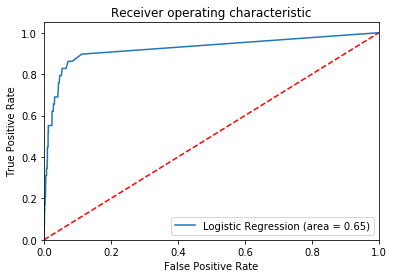

In [33]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [34]:
with open('mvp.model', 'wb') as f:
    pickle.dump(model, f)
f.close()